# Data Scraping/ Gathering

In [ ]:
import re
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

## Scrape Title, Price and link details

In [ ]:
URL = 'https://www.ebay.com/sch/i.html'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

title = []
price = []
product_link = []
shipping =[]
discount = []
actual_price = []

for page_number in range(1, 50):
    params = {
        '_from': 'R40',
        '_nkw': 'mobiles',
        '_pgn': page_number,
        '_ipg': 240
    }

    page = requests.get(URL, params=params, headers=headers)

    if page.status_code == 200:
        soup = BeautifulSoup(page.text, 'html.parser')
        product_title = soup.find_all('div', class_ = 's-item__title' )
        product_price = soup.find_all('span', class_ = 's-item__price')
        product_divs = soup.find_all('div', class_='s-item__info clearfix')
        for item_text,item_price,product_div in zip(product_title, product_price,product_divs):
          if item_text.text !="Shop on eBay":
            title.append(item_text.text)
            price.append(item_price.text)
            link = product_div.find('a', class_='s-item__link')['href']
            product_link.append(link)
    else:
        print(f"Error: {page.status_code}")

In [ ]:
product_id = []
for i in product_link:
  product_id.append(re.findall(r'/itm/(.*)\?',i)[0])

## Scrape Product details for each Product

In [ ]:
product_details_list = []

for item_id in product_id:
    url = f'https://www.ebay.com/itm/{item_id}'
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')

    item = {}
    section_title_elements = soup.select('.section-title')

    for section_title_element in section_title_elements:
        if 'Item specifics' in section_title_element.text:
            section_element = section_title_element.parent

            for section_col in section_element.select('.ux-layout-section-evo__col'):
                col_label = section_col.select_one('.ux-labels-values__labels')
                col_value = section_col.select_one('.ux-labels-values__values')

                if col_label is not None and col_value is not None:
                    item[col_label.text.strip()] = col_value.text.strip()

    product_details_list.append(item)

In [ ]:
product_details_list

[{'Condition': "New: A brand-new, unused, unopened, undamaged item in its original packaging (where packaging is ...  Read moreabout the conditionNew: A brand-new, unused, unopened, undamaged item in its original packaging (where packaging is applicable). Packaging should be the same as what is found in a retail store, unless the item is handmade or was packaged by the manufacturer in non-retail packaging, such as an unprinted box or plastic bag. See the seller's listing for full details. See all condition definitionsopens in a new window or tab",
  'Brand': 'Unbranded',
  'Model': 'S23+ Ultra',
  'Storage Capacity': '256 GB',
  'Camera Resolution': '50MP+108MP',
  'Screen Size': '7.3in',
  'Lock Status': 'Factory Unlocked',
  'Connectivity': '2G, 3G, 4G, 5G, GPRS, GPS, Wi-Fi',
  'Processor': '10 Core',
  'Features': 'Bluetooth Enabled, Camera, Color Screen, Facial Recognition, Fingerprint Sensor, FM Radio, Front Camera, GPRS, GPS, Music Player, Nano SIM, Rear Camera, Stylus, Touch Scr

In [ ]:
len(product_details_list)

10088

## Extract the important features from the page

In [ ]:
ram = []
processor = []
model = []
screen_size = []
connectivity = []
operating_system = []
camera_resolution = []
storage_capacity = []
brand = []

for product_details in product_details_list:
    ram_value = product_details.get('RAM')
    processor_value = product_details.get('Processor')
    model_value = product_details.get('Model')
    screen_size_value = product_details.get('Screen Size')
    connectivity_value = product_details.get('Connectivity')
    os_value = product_details.get('Operating System')
    camera_value = product_details.get('Camera Resolution')
    storage_value = product_details.get('Storage Capacity')
    brand_type=product_details.get('Brand')


    ram.append(ram_value)
    processor.append(processor_value)
    model.append(model_value)
    screen_size.append(screen_size_value)
    connectivity.append(connectivity_value)
    operating_system.append(os_value)
    camera_resolution.append(camera_value)
    storage_capacity.append(storage_value)
    brand.append(brand_type)

sales = pd.DataFrame({'Name': title, 'ID' : product_id ,'RAM': ram, 'Processor': processor, 'Model': model,'Brand': brand ,'Screen Size': screen_size, 'Connectivity': connectivity, 'OS': operating_system, 'Camera': camera_resolution, 'Storage': storage_capacity, 'Price': price})

In [ ]:
sales.head()

,Name,ID,RAM,Processor,Model,Brand,Screen Size,Connectivity,OS,Camera,Storage,Price
0,"S23+ Ultra 5G Smartphone 7.3"" 8GB+256GB Factor...",375090547608,8GB,10 Core,S23+ Ultra,Unbranded,7.3in,"2G, 3G, 4G, 5G, GPRS, GPS, Wi-Fi",Android,50MP+108MP,256 GB,$138.69
1,OnePlus 10T 5G 128GB Moonstone Black T-Mobile...,185997734023,8 GB,Octa Core,OnePlus 10T 5G,OnePlus,6.7 in,"USB Type-C, 5G, Bluetooth, Wi-Fi, NFC",OxygenOS,50.0 MP,128 GB,$299.99
2,Bullitt Mobile CAT S22 FLIP 16GB - Black - (T-...,175607425480,None,None,S22,CAT,None,None,None,None,16 GB,$45.99
3,Apple iPhone 12 64GB Factory Unlocked AT&T T-M...,304078563335,4 GB,Hexa Core,Apple iPhone 12,Apple,6.1 in,"4G, Bluetooth, NFC, Wi-Fi, Lightning, 5G",iOS,12.0 MP,64 GB,$284.95
4,Apple iPhone 6S (Excellent Condition) Factory ...,114996232299,2 GB,Dual Core,iPhone 6s,Apple,4.7 in,"2G, 3G, 4G, 5G, Bluetooth, GPS, LTE, NFC, Wi-Fi",iOS,12.0 MP,None,$47.00 to $108.00


In [ ]:
sales['Price']

0                   $138.69
1                   $299.99
2                    $45.99
3                   $284.95
4         $47.00 to $108.00
                ...        
10083               $300.00
10084                $25.00
10085               $118.55
10086    $172.00 to $302.00
10087               $299.00
Name: Price, Length: 10088, dtype: object

In [ ]:
#covert to string
sales['Price'] = sales['Price'].astype(str)

In [ ]:
# remove dollar sign
sales['Price'] = sales['Price'].str.replace('$', '')

In [ ]:
#Checking the duplicate values.
sales.duplicated().sum()

1953

In [ ]:
 # drop duplicates
sales.drop_duplicates(inplace=True)

In [ ]:
#convert sales data to CSV
sales.to_csv('Ebay-Mobiles.csv')

#Data Cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read sales csv file
sales=pd.read_csv("Ebay-Mobiles.csv")

In [ ]:
sales

,Unnamed: 0,Name,ID,RAM,Processor,Model,Brand,Screen Size,Connectivity,OS,Camera,Storage,Price
0,0,"S23 Ultra 5G Unlocked Smartphone OLED 7.3"" 4GB...",314965513410,4 GB,Qualcomm SM8550,S23 Ultra 5G,Unbranded,7.3in,"2G,3G,4G,5G,GPS,LTE,NFC,USBType-C,Wi-Fi",Android,50.0 MP,128 GB,119.99 to 135.99
1,1,OnePlus 10T 5G 128GB Moonstone Black T-Mobile...,185997734023,8 GB,Octa Core,OnePlus 10T 5G,OnePlus,6.7 in,"USB Type-C, 5G, Bluetooth, Wi-Fi, NFC",OxygenOS,50.0 MP,128 GB,269.99
2,2,Apple iPhone 11 - 128GB - A2111 Fully Unlocked...,115382465534,2 GB,NaN,Apple iPhone 11,Apple,NaN,"LTE, 2G, 3G, 4G, 5G, WI-FI, NFC, GPS, Bluetooth",iOS,12.0 MP,NaN,178.00 to 369.00
3,3,"S23 Ultra Smartphone 7.3"" 4+64GB Android Facto...",385620301013,4 GB,10 Core,S23 Ultra,Unbranded,7.3 in,"3G, 4G, 5G, GPS, LTE, USB Type-C, Wi-Fi",Android,Front 50MP+Rear 108MP,64 GB,109.47
4,4,Apple iPhone 8 64GB 128GB 256GB Unlocked ATT T...,175358971572,2 GB,Quad Core,Apple iPhone 8,Apple,4.7 in,"4G, Bluetooth, GPS",iOS,12.0 MP,NaN,99.98 to 109.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8503,10081,Samsung Entro Flip Phone Paylo Virgin Mobile C...,184990764027,unknown,Quad Core,Entro,Samsung,1.8 in,2G,Android,8.0 MP,128 MB,40.00
8504,10083,Motorola Moto G 3rd Gen (XT1548) 8GB Black Vir...,132960608776,NaN,NaN,Motorola Moto G 3rd Gen,Motorola,NaN,NaN,Android,NaN,8GB,33.20
8505,10084,Rare Original Samsung SGH-R200s Flip GSM mobil...,225855677808,NaN,NaN,SGH-R200s,Samsung,128 x 64 pixels,2G,NaN,NaN,"10 dialed, 10 received, 10 missed calls",100.00
8506,10086,REVVL 4 TMRVL4G Cellphone (Black 32GB) T-Mobile,386261981506,NaN,NaN,Revvl 4,PowerbookMedic,NaN,NaN,NaN,NaN,32GB,43.00


In [ ]:
# remove un necessary columns
sales = sales.drop('Unnamed: 0', axis =1)

In [ ]:
#Checking the Null values and Counting the Null values
sales.isnull().sum() /len(sales)*100

Name             0.000000
ID               0.000000
RAM             47.813822
Processor       48.683592
Model            3.173484
Brand            0.317348
Screen Size     38.269864
Connectivity    38.081805
OS              29.666197
Camera          36.694875
Storage         10.625294
Price            0.000000
dtype: float64

In [ ]:
#remove null values from the columns
sales.dropna(subset =['Model','Storage','Brand' ], inplace = True)

In [ ]:
#know about data
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 8507
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          7453 non-null   object
 1   ID            7453 non-null   int64 
 2   RAM           4045 non-null   object
 3   Processor     4076 non-null   object
 4   Model         7453 non-null   object
 5   Brand         7453 non-null   object
 6   Screen Size   4919 non-null   object
 7   Connectivity  4800 non-null   object
 8   OS            5460 non-null   object
 9   Camera        4938 non-null   object
 10  Storage       7453 non-null   object
 11  Price         7453 non-null   object
dtypes: int64(1), object(11)
memory usage: 756.9+ KB


In [ ]:
# Replace null values to NA
sales.fillna('NA', inplace=True)

In [ ]:
#Checking the Null values and Counting the Null values
sales.isnull().sum()

Name            0
ID              0
RAM             0
Processor       0
Model           0
Brand           0
Screen Size     0
Connectivity    0
OS              0
Camera          0
Storage         0
Price           0
dtype: int64

## Cleaning RAM column

In [ ]:
sales['RAM'] = sales.RAM.astype(str)

In [ ]:
sales['RAM'] = sales['RAM'].str.strip()
sales['RAM'] = sales['RAM'].str.replace(' RAM', '')

In [ ]:
import re
def clean_ram(value):
    # Convert to string and handle special cases
    value = str(value).lower()

    # Extract numeric values using regular expression
    number = re.search(r'(\d+(\.\d+)?)', value)

    # Check if a numeric value is found
    if number:
        number = float(number.group(1))

        # Check for 'GB' or 'MB' in the original string
        if 'gb' in value:
            return number * 1024  # Convert GB to MB
        elif 'mb' in value:
            return number

    # return NaN for unknown values
    return np.nan

In [ ]:
# apply above function to standardize the values
sales['RAM'] = sales['RAM'].apply(clean_ram)

In [ ]:
# to check if all values are unique
sales["RAM"].unique()

array([4.0960e+03, 8.1920e+03,        nan, 1.2288e+04, 1.6384e+04,
       6.1440e+03, 2.0480e+03, 3.0720e+03, 1.0240e+03, 2.5600e+02,
       4.0000e+00, 5.1200e+02, 3.2000e+01, 1.1264e+04, 1.5360e+03,
       2.2528e+04, 1.2800e+02, 2.0480e+04, 2.8800e+02, 6.1440e+01,
       6.4000e+01, 1.2000e+01, 5.1200e+03, 8.0000e+00, 7.6800e+02,
       4.8000e+01, 1.6500e+02, 1.6000e+01, 2.5000e+02, 2.0000e+00,
       9.6000e+01, 1.0000e+02, 3.0000e+00, 6.5536e+04, 7.0000e+01,
       5.0000e+01, 1.8400e+02, 5.2000e+01, 3.2768e+04, 1.0240e+04,
       6.0000e+01, 5.7600e+02, 1.9456e+03, 3.0720e+01, 2.9000e+02,
       7.1680e+03, 3.0000e+01, 4.0000e+01])

## Cleaning Processor column

In [ ]:
sales['Processor']= sales['Processor'].replace(['NA','NO','N/A','other','N/a','..','Unk','other', 'Other','1', 'not  applicable','Unknown', 'not sure', '?', 'unclear', 'N/a', 'See Details','No', 'See description for details', 'multiple', 'not applicable','(H80XAH6QR2AN)','(NG502LL/A)','(Unknown Model)','*','/','Not specified', 'Not available'], 'NA')
sales['Processor']= sales['Processor'].replace(['N','no','.','none', 'not applicable', 'n/a','Do not know','see details', 'not sure', 'unclear', 'unknown', '?', 'see description for details', 'multiple', 'not specified', 'not available','NO', 'Not Applicable'], 'NA')
sales['Processor']= sales['Processor'].replace(['Various by Model Selected', '--'], 'NA')

In [ ]:
def clean_processor_value(value):

    value_lower = str(value).lower()
    if 'octa' in value_lower:
        return 'Octa Core'
    elif 'hexa' in value_lower:
        return 'Hexa Core'
    elif 'quad' in value_lower:
        return 'Quad Core'
    elif 'dual' in value_lower:
        return 'Dual Core'
    elif 'core' in value_lower and 'deca' in value_lower or '10'in value_lower:
        return 'Deca Core'
    elif 'core' in value_lower and 'nona' in value_lower:
        return 'Nona Core'
    elif 'core' in value_lower and 'single' in value_lower:
        return 'Single Core'
    else:
        return value
sales['Processor'] = sales['Processor'].apply(clean_processor_value)

In [ ]:
sales['Processor'].unique()

array(['Qualcomm SM8550', 'Octa Core', 'Deca Core', 'NA', 'Hexa Core',
       '2.8 GHz Qualcomm Snapdragon 855', 'Qualcomm Snapdragon 888',
       'Qual Comm', 'Quad Core', 'Exynos 1280', 'Apple A14 Bionic',
       'SNAPDRAGON', 'A15 Bionic', 'Snapdragon 8+ Gen 1', 'Dual Core',
       'Single Core', 'Qualcomm', 'A14 Bionic',
       'Qualcomm Snapdragon 8 Gen 1', 'Apple A9', 'A13 Bionic',
       '1.2 GHz Qualcomm Snapdragon 215', 'Varies by Model Selected',
       'MediaTek Helio G25', 'Snapdragon 675',
       'Snapdragon 695 5G Up to 2.2GHz', '1.6 GHz Samsung Exynos 7884',
       'Octo Core', '64bit - Qualcomm Snapdragon 865+ SM8250 (7nm)',
       'MediaTek MT6765', 'Apple A13 Bionic', 'MediaTek MT6750S',
       '2.2 GHz Qualcomm Snapdragon 820', 'A15', 'Exynos 7884',
       '2.8 GHz Qualcomm Snapdragon 845',
       '1.4 GHz Qualcomm Snapdragon 425', 'Qualcomm Snapdragon 821',
       '1.8 GHz Qualcomm Snapdragon 665', 'Qualcomm Snapdragon 450',
       'Apple A8', '2 GHz Qualcomm Snapdr

In [ ]:
sales['Model']= sales['Model'].replace(['(H80XAH6QR2AN)','(NG502LL/A)','(Unknown Model)','*','/','N\A','ukn','Unknown','None','NO','other','unknown'], 'NA')

## Cleaning Brand Column

In [ ]:
sales["Brand"] = sales["Brand"].str.lower()

In [ ]:
brand_mapping = {
    'viqee/customization': 'ViQee',
    'unbranded/generic': 'na',
    'aa': 'AA',
    'does not apply': 'na',
    'sony|sony ericsson|lg': 'sony',
    'various': 'na',
    'letv leeco le s3 x626': 'LeEco',
    'p.c.d.': 'PCD',
    'clearphone 220': 'ClearPHONE 220',
    'nokia c5-00 unlocked mobile phone white': 'nokia',
    'samsung electronics': 'samsung',
    'nokia 6120 classic 6120c unlocked mobile phone whi': 'nokia'
}

In [ ]:
sales['Brand'].replace(['NA', 'N/A', 'unknown','na'], 'NA', inplace=True)
sales['Brand'].replace(['myphone', 'Unbranded'], 'NA', inplace=True)

In [ ]:
sales["Brand"] = sales["Brand"].replace(brand_mapping)

In [ ]:
sales["Brand"].unique()

array(['unbranded', 'oneplus', 'cat', 'apple', 'samsung', 'tcl',
       't-mobile', 'lg', 'motorola', 'coolpad', 'nokia', 'wingtech',
       'alcatel', 'nhee', 'google', 'cloud mobile', 'blackberry', 'htc',
       'simple mobile', 'nuu mobile', 'xgody', 'itelco', 'toshiba',
       'at&t', 'sonim', 'at&t unlocked', 'kyocera', 'senwa', 'palm',
       'ulefone', 'sony', 'qin', 'wiko', 'microsoft lumia', 'agm',
       'orbic', 'doogee', 'soyes', 'schok', 'hotpepper', 'emblem', 'zte',
       'ans', 'vortex', 'lanxus', 't mobile', 'fossibot', 'artfone',
       'stratus', 'anysecu', 'posh mobile', 'verizon wireless', 'jja',
       'plum', 'energizer', 'umidigi', 'asus', 'sony ericsson',
       'alcatelonetouch', 'lge', 'cloud', 'hotwav', 'meizu', 'AA',
       'verizon', 'x-mobile', 'mparty', 'revvl', 'panasonic',
       'android mobile phone', 'siemens', 'levis', 'zuum', 'xiaomi',
       'huawei', 'NA', 'celero', 'na', 'sanyo', 'tinno', 'emporia',
       'pcl_00n9alu7', 'metro by t-mobile', '

## Cleaning Connectivity Column

In [ ]:
#Handling missing values
sales["Connectivity"].replace(["NA", "N/A", "unknown", "na"], 'NA', inplace=True)
#Categorizing similar responses
sales["Connectivity"].replace(["see specifications", "see description for details"], "NA", inplace=True)

In [ ]:
sales["Connectivity"].head()

0     2G,3G,4G,5G,GPS,LTE,NFC,USBType-C,Wi-Fi
1       USB Type-C, 5G, Bluetooth, Wi-Fi, NFC
3     3G, 4G, 5G, GPS, LTE, USB Type-C, Wi-Fi
5                                          NA
7    4G, Bluetooth, NFC, Wi-Fi, Lightning, 5G
Name: Connectivity, dtype: object

### Split the Connectivity column into multiple columns

In [ ]:
technologies = ['2G', '3G', '4G', '5G', 'Bluetooth', 'DLNA', 'Dual-Band', 'GPRS', 'GPS', 'LTE', 'NFC', 'USB Type-C', 'Wi-Fi','Lightning','Micro USB','WAP']

In [ ]:
for tech in technologies:
    sales[tech] = sales['Connectivity'].str.contains(tech, case=False)

In [ ]:
sales.columns

Index(['Name', 'ID', 'RAM', 'Processor', 'Model', 'Brand', 'Screen Size',
       'Connectivity', 'OS', 'Camera', 'Storage', 'Price', '2G', '3G', '4G',
       '5G', 'Bluetooth', 'DLNA', 'Dual-Band', 'GPRS', 'GPS', 'LTE', 'NFC',
       'USB Type-C', 'Wi-Fi', 'Lightning', 'Micro USB', 'WAP'],
      dtype='object')

In [ ]:
sales['Connectivity'].unique()

array(['2G,3G,4G,5G,GPS,LTE,NFC,USBType-C,Wi-Fi',
       'USB Type-C, 5G, Bluetooth, Wi-Fi, NFC',
       '3G, 4G, 5G, GPS, LTE, USB Type-C, Wi-Fi', 'NA',
       '4G, Bluetooth, NFC, Wi-Fi, Lightning, 5G', '5G',
       '4G, 4G+, 5G, Bluetooth, GPS',
       '2G, 3G, 4G, 4G+, Bluetooth, DLNA, Dual-Band, GPRS, GPS',
       '3G, 4G, 5G, Bluetooth, USB Type-C, Wi-Fi',
       '3G, 4G, 5G, Bluetooth, GPS, Micro USB, Wi-Fi',
       '2G,3G,4G,5G,GPS,LTE,USBType-C,Wi-Fi',
       '4G, Bluetooth, NFC, Wi-Fi, Lightning',
       'LTE, 2G, 3G, 4G, 5G, WI-FI, NFC, GPS, Bluetooth',
       '5G, Bluetooth, GPS, Headphone Jack, LTE, NFC, USB Type-C, Wi-Fi',
       'Bluetooth, 4G, 3G, Wi-Fi, 2G, Micro USB, GPS, LTE',
       '4G, 4G+, LTE, USB Type-C, 5G, Bluetooth, Wi-Fi, NFC, GPS',
       '2G, 3G, 4G', '3G, 4G, 5G, Bluetooth, GPS, USB Type-C, Wi-Fi',
       'Bluetooth, Headphone Jack, Wi-Fi, NFC, GPS, USB Type-C, 5G, 4G, 3G, 2G, DLNA, LTE, Dual-Band',
       '2G, Bluetooth, Quad-Band', '2G, 3G, 4G, 5G, Blu

## Cleaning Camera Column

In [ ]:
sales['Camera'].unique()

array(['50.0 MP', 'Front 50MP+Rear 108MP', 'NA', '12.0 MP', '16.0 MP',
       '108.0MP', '50MP+108MP', '12.0MP', '48.0 MP', '108.0 MP',
       '64.0 MP', '5.0 MP', '48MP+72MP', '12.0 MP, 64.0 MP', '13.0 MP',
       '50MP x 108MP', '0.3 MP, 64.0 MP, 13.0 MP, 10.0 MP', '0.3 MP',
       '48MP + 72MP', '128', '12.0 - 15.9 MP',
       '12.0 MP, 50.0 MP, 10.0 MP', '100.0MP', '16 mp', '50.0 Megapixel',
       '8.0 MP', '2.0 MP', 'Not Applicable', '5.0 MP, 13.0 MP, 2.0 MP',
       '108MP', '8.0 MP, 25.0 MP', '12.0 MP, 8.0 MP', '16.0MP, 12.2 MP',
       '16.0MP', '8MP Rear + 5MP Front', '40 megapixels', '0.08MP',
       '12.0 MP, 5.0 MP, 64.0 MP',
       '50MP Wide + 12MP Ultra Wide + 10MP Tele 3x Optical Zoom',
       '7.0 MP', '3.0 MP', '8.0 MP, 25.0 MP, 5.0MP',
       'Front 48MP+Rear 100MP', '50 MP', '12MP', '12.0 MP, 48.0 MP',
       '8.0 MP+12.0 MP+12.0 MP', '12.0 MP, 12.2 MP', '2 MP',
       'Pro 12MP camera system: Telephoto, Wide, and Ultra', '25.0 MP',
       '12.8.MP', '8.0 MP, 50.0 

In [ ]:
sales['Camera'] = sales['Camera'].replace(["Varies by selection","none", "Yes", "na","VGA","VGA with flash", "Not Applicable","See description for details","Dose Not Apply","NO","Does not apply","Dose not apply", "NO Camera","NONE",".","Not specified","Standard",'None', '?','not sure','No camera','Unknown','NO CAMERA','See Photos','no','LOCKED UNKNOWN',],"NA")

In [ ]:
# Function to clean and standardize the camera specification
def clean_camera_spec(camera_spec):
    if pd.isna(camera_spec):
        return None
    mp_values = []
    for val in camera_spec.split('+'):
        mp_part = ''.join(filter(str.isdigit, val.split('MP')[0]))
        if mp_part.isdigit():
            mp_values.append(mp_part + ' MP')

    # Join the cleaned values
    cleaned_camera_spec = ' '.join(mp_values)
    return cleaned_camera_spec
# Clean each camera specification in the DataFrame
sales['Camera'] = [clean_camera_spec(spec) for spec in sales['Camera']]

### Convert Camera column into Megapixels Column

In [ ]:
sales['MegaPixels'] = sales['Camera'].str.extract('(\d+\.\d+|\d+)').astype(str)

In [ ]:
sales['MegaPixels'] = sales['MegaPixels'].replace(['nanMP'],"NA")

In [ ]:
sales['MegaPixels'].unique()

array(['500', '50', 'nan', '120', '160', '1080', '480', '640', '48',
       '130', '03', '128', '120159', '1000', '16', '80', '20', '108', '8',
       '40', '008', '70', '30', '12', '2', '250', '64', '13', '32', '5',
       '150', '320', '200', '121', '315', '4', '37', '05', '123', '610',
       '10', '131', '190', '01', '180', '100', '240', '3', '21601080402',
       '640480', '210', '2000', '24', '67', '5080', '400', '87', '199',
       '9668', '21', '207', '230', '7201440', '23', '31', '5013020', '81',
       '61', '19'], dtype=object)

## Cleaning OS Column

In [ ]:
sales['OS'] = sales['OS'].replace(['not applicable','Others' ,'see description for details','unknown','None'],"NA")
sales['OS'] = sales['OS'].replace(['â€z']," ")

In [ ]:
# Define a function to categorize the operating systems
def categorize_os(os):
    os = os.lower()
    if 'android' in os:
        return 'Android'
    elif 'ios' in os or 'apple' in os:
        return 'iOS'
    elif 'windows' in os:
        return 'Windows'
    elif 'symbian' in os:
        return 'Symbian'
    elif 'kaios' in os:
        return 'KaiOS'
    elif 'linux' in os:
        return 'Linux'
    elif 'blackberry' in os:
        return 'BlackBerry'
    elif 'nokia' in os:
        return 'Nokia'
    elif 'proprietary' in os or 'unknown' in os or 'no smartphone' in os or 'na' in os or 'none' in os:
        return 'NA'
    else:
        return 'NA'

# Apply the categorize_os function to the 'Operating System' column
sales['OS'] = sales['OS'].apply(categorize_os)


In [ ]:
sales['OS'].unique()

array(['Android', 'NA', 'iOS', 'Symbian', 'BlackBerry', 'Windows',
       'Linux', 'Nokia'], dtype=object)

## Cleaning Storage Column

In [ ]:
sales['Storage'] = sales['Storage'].apply(clean_ram)

In [ ]:
sales['Storage'].unique()

array([1.31072e+05, 6.55360e+04,         nan, 2.62144e+05, 3.27680e+04,
       1.63840e+04, 5.00000e+00, 4.09600e+03, 8.19200e+03, 1.28000e+02,
       1.00000e+00, 2.04800e+03, 5.24288e+05, 2.56000e+02, 5.12000e+02,
       1.02400e+03, 4.00000e+00, 3.20000e+01, 1.60000e+02, 2.60000e+02,
       1.60000e+01, 1.70000e+02, 7.80000e+00, 6.40000e+01, 5.00000e+01,
       1.05000e+01, 2.00000e+00, 2.88000e+02, 1.02400e+04, 2.80000e+01,
       4.80000e+01, 1.15000e+02, 1.00000e+01, 3.00000e+00, 3.60000e+01,
       8.76000e+01, 6.00000e+01, 3.20000e+00, 7.50000e+01, 4.00000e+01,
       2.50000e+01, 2.58000e+02, 1.50000e+00, 2.00000e+01, 2.50000e+02,
       8.00000e+00, 7.10000e+01, 7.00000e+01, 2.90000e+01, 8.00000e+01,
       1.80000e+00, 4.40000e+00, 9.00000e+00, 3.50000e+00, 1.50000e+01,
       6.14400e+03, 1.70000e+01, 6.00000e+00, 3.00000e+01, 2.70000e+02,
       2.10000e+00, 2.10000e+01, 1.00000e+02, 1.10000e+01, 5.50000e+01,
       1.20000e+01, 1.30000e+02, 1.65000e+02, 2.20000e+01, 4.500

## Cleaning Screen Size Column

In [ ]:
sales['Screen Size'] = sales['Screen Size'].replace(['na','???','Unknown','other','See description for details','unknown','Multiple', 'Not specified','as shown','None', 'multiple','Normal','Alphanumeric 1 x 10 chars','0.8&quot;', 'As Describe'],'NA')

In [ ]:
pixel_pattern = re.compile(r'\d+\s*x\s*\d+')
sales['Screen Size'] = sales['Screen Size'].astype(str).str.replace(pixel_pattern, 'NA')

In [ ]:
def extract_inches(text):
    matches = re.findall(r'(\d+(\.\d+)?)', str(text))
    return matches[0][0] if matches else None

In [ ]:
sales['Screen Size'] = sales['Screen Size'].apply(extract_inches)

In [ ]:
sales['Screen Size'].unique()

array(['7.3', '6.7', None, '6.1', '6.8', '6.5', '6.4', '2.8', '5.8',
       '6.2', '6.3', '2.2', '6.9', '6.43', '4.7', '5.7', '5.4', '6.6',
       '5.1', '4', '7.0', '2.4', '6.52', '5.5', '5', '1.8', '4.3', '6.53',
       '2.7', '1.77', '6.55', '6.81', '3', '2.6', '3.3', '1', '7.2',
       '6.82', '4.5', '6.47', '6.517', '3.5', '3.2', '4.9', '6', '6.58',
       '3.0', '6.67', '5.45', '3.4', '5.42', '6.49', '4.8', '5.6', '2.1',
       '5.54', '5.83', '6.77', '5.3', '2', '6.75', '2.5', '1.9', '7.6',
       '1.44', '1.43', '5.0', '1.36', '0.66', '5.9', '2.0', '3.8', '6.99',
       '1.4', '2.36', '1.5', '1.7', '5.2', '4.0', '7', '3.7', '130',
       '1.45', '6.22', '2.75', '6.78', '6.0', '3.1', '6.583', '2.31',
       '1.6', '6.26', '6.15', '1.39', '2.30', '6.088', '6.21', '3.6',
       '38', '1.78', '0.79', '4.6', '8', '2.3', '2.9', '4.55', '6.72',
       '1.17', '6.44', '6.62', '2.55', '6.09', '6.76', '6.59', '3.22',
       '4.2', '1.63', '1.54', '5.65', '1.85', '1.52', '4.1', '5.84',
  

## Cleaning Price Column

In [ ]:
def calculate_average(price_range):
    price_range = price_range.replace(',', '')
    if ' to ' in price_range:
        low, high = price_range.split(' to ')
        return (float(low) + float(high)) / 2
    else:
        return float(price_range)

# Apply the function to the price column
sales['price_avg'] = sales['Price'].apply(calculate_average)

sales['price_avg']

0       127.99
1       269.99
3       109.47
5        79.99
7       284.95
         ...  
8503     40.00
8504     33.20
8505    100.00
8506     43.00
8507    236.00
Name: price_avg, Length: 7453, dtype: float64

In [ ]:
sales.columns

Index(['Name', 'ID', 'RAM', 'Processor', 'Model', 'Brand', 'Screen Size',
       'Connectivity', 'OS', 'Camera', 'Storage', 'Price', '2G', '3G', '4G',
       '5G', 'Bluetooth', 'DLNA', 'Dual-Band', 'GPRS', 'GPS', 'LTE', 'NFC',
       'USB Type-C', 'Wi-Fi', 'Lightning', 'Micro USB', 'WAP', 'MegaPixels',
       'price_avg'],
      dtype='object')

## Drop Columns

In [ ]:
sales = sales.drop(['Connectivity','Camera', 'Price'], axis = 1)

In [ ]:
#Rename MegaPixels to Camera, Storage_new to Storage, price_avg to Price
sales.rename(columns={'MegaPixels': 'Camera', 'price_avg': 'Price'}, inplace=True)

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 8507
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         7453 non-null   object 
 1   ID           7453 non-null   int64  
 2   RAM          3846 non-null   float64
 3   Processor    7453 non-null   object 
 4   Model        7453 non-null   object 
 5   Brand        7453 non-null   object 
 6   Screen Size  4882 non-null   object 
 7   OS           7453 non-null   object 
 8   Storage      6678 non-null   float64
 9   2G           7453 non-null   bool   
 10  3G           7453 non-null   bool   
 11  4G           7453 non-null   bool   
 12  5G           7453 non-null   bool   
 13  Bluetooth    7453 non-null   bool   
 14  DLNA         7453 non-null   bool   
 15  Dual-Band    7453 non-null   bool   
 16  GPRS         7453 non-null   bool   
 17  GPS          7453 non-null   bool   
 18  LTE          7453 non-null   bool   
 19  NFC   

## Convert the Columns into Float Datatype

In [ ]:
sales['Screen Size'] = sales['Screen Size'].astype(float)
sales['Camera'] = sales['Camera'].astype(float)

## Check Null values

In [ ]:
sales.isnull().sum() *100/len(sales)

Name            0.000000
ID              0.000000
RAM            48.396619
Processor       0.000000
Model           0.000000
Brand           0.000000
Screen Size    34.496176
OS              0.000000
Storage        10.398497
2G              0.000000
3G              0.000000
4G              0.000000
5G              0.000000
Bluetooth       0.000000
DLNA            0.000000
Dual-Band       0.000000
GPRS            0.000000
GPS             0.000000
LTE             0.000000
NFC             0.000000
USB Type-C      0.000000
Wi-Fi           0.000000
Lightning       0.000000
Micro USB       0.000000
WAP             0.000000
Camera         35.972092
Price           0.000000
dtype: float64

##Dropping the ID Column

In [ ]:
#remove unnecessary columns
sales= sales.drop('ID',axis=1)

## Fill the Data with Mode

In [ ]:
def fill_with_mode(series):
    mode = series.mode()
    if mode.empty:
        return series.fillna(series.median())
    else:
        return series.fillna(mode.iloc[0])

# Fill the colums with Mode
sales['RAM'] = sales.groupby(['Brand', 'Processor'])['RAM'].transform(fill_with_mode)
sales['Screen Size'] = sales.groupby(['Brand', 'OS'])['Screen Size'].transform(lambda x: x.fillna(x.mean()))
sales['Camera'] = sales.groupby(['Brand', 'Model'])['Camera'].transform(lambda x: x.fillna(x.mean()))

# For other columns with float type, fill with mean, and for others, fill with mode
sales = sales.apply(lambda x: x.fillna(x.mean()) if x.dtype == 'float' else fill_with_mode(x))


# Final Data

In [ ]:
sales

,Name,RAM,Processor,Model,Brand,Screen Size,OS,Storage,2G,3G,...,GPS,LTE,NFC,USB Type-C,Wi-Fi,Lightning,Micro USB,WAP,Camera,Price
0,"S23 Ultra 5G Unlocked Smartphone OLED 7.3"" 4GB...",4096.000000,Qualcomm SM8550,S23 Ultra 5G,unbranded,7.300000,Android,131072.000000,True,True,...,True,True,True,False,True,False,False,False,5.000000e+02,127.99
1,OnePlus 10T 5G 128GB Moonstone Black T-Mobile...,8192.000000,Octa Core,OnePlus 10T 5G,oneplus,6.700000,NA,131072.000000,False,False,...,False,False,True,True,True,False,False,False,5.000000e+02,269.99
3,"S23 Ultra Smartphone 7.3"" 4+64GB Android Facto...",4096.000000,Deca Core,S23 Ultra,unbranded,7.300000,Android,65536.000000,False,True,...,True,True,False,True,True,False,False,False,5.000000e+01,109.47
5,Cat S62 SMARTPHONE S62 T-Mobile Unlocked 128GB...,3965.113093,NA,S62 SMARTPHONE,cat,4.703390,NA,131072.000000,False,False,...,False,False,False,False,False,False,False,False,9.284761e+06,79.99
7,Apple iPhone 12 64GB Factory Unlocked AT&T T-M...,4096.000000,Hexa Core,Apple iPhone 12,apple,6.100000,iOS,65536.000000,False,False,...,False,False,True,False,True,True,False,False,1.200000e+02,284.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8503,Samsung Entro Flip Phone Paylo Virgin Mobile C...,4096.000000,Quad Core,Entro,samsung,1.800000,Android,128.000000,True,False,...,False,False,False,False,False,False,False,False,8.000000e+01,40.00
8504,Motorola Moto G 3rd Gen (XT1548) 8GB Black Vir...,2048.000000,NA,Motorola Moto G 3rd Gen,motorola,6.072032,Android,8192.000000,False,False,...,False,False,False,False,False,False,False,False,9.284761e+06,33.20
8505,Rare Original Samsung SGH-R200s Flip GSM mobil...,8192.000000,NA,SGH-R200s,samsung,3.152045,NA,63114.861894,True,False,...,False,False,False,False,False,False,False,False,9.284761e+06,100.00
8506,REVVL 4 TMRVL4G Cellphone (Black 32GB) T-Mobile,3965.113093,NA,Revvl 4,powerbookmedic,4.703390,NA,32768.000000,False,False,...,False,False,False,False,False,False,False,False,9.284761e+06,43.00


# Data Visualization

## Calculate the value counts and select the top 10 Brands

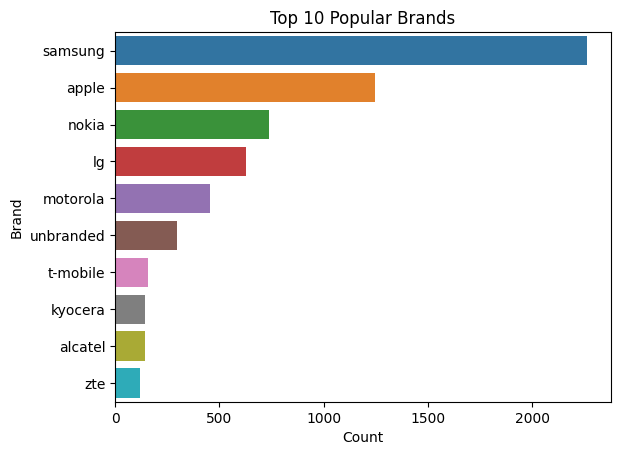

In [ ]:
top_10_brands = sales['Brand'].value_counts().head(10)
sns.countplot(y='Brand', data=sales, order=top_10_brands.index)
plt.title('Top 10 Popular Brands')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.show()


## Plot showing the relation of RAM and Storage

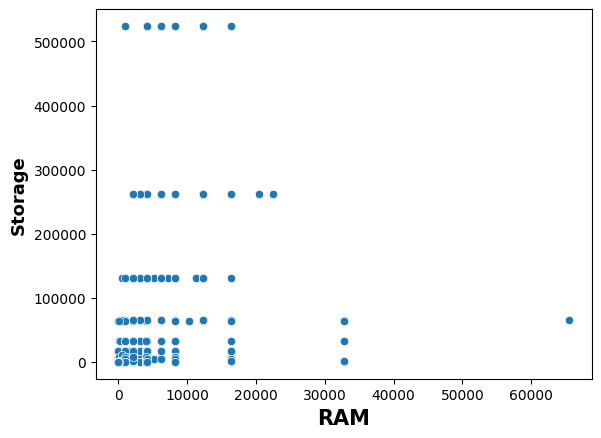

In [ ]:
sns.scatterplot(x= sales["RAM"], y= sales["Storage"] )
plt.ylabel("Storage", fontsize= 13, fontweight="bold")
plt.xlabel("RAM", fontsize=15, fontweight="bold")
plt.show()

## Plot of Screen Sizes for top 10 Brands

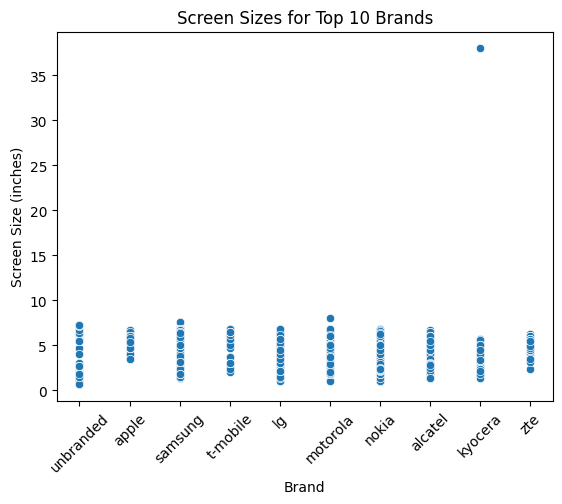

In [ ]:

top_10_brands = sales['Brand'].value_counts().head(10).index
top_10_sales = sales[sales['Brand'].isin(top_10_brands)]
sns.scatterplot(x='Brand', y='Screen Size', data=top_10_sales)
plt.xticks(rotation=45)
plt.title('Screen Sizes for Top 10 Brands')
plt.xlabel('Brand')
plt.ylabel('Screen Size (inches)')
plt.show()


## Plot for OS distribution

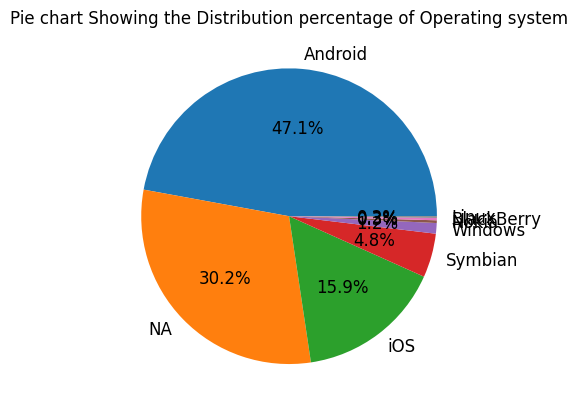

In [ ]:
os_counts = sales['OS'].value_counts()
os_counts.plot(kind='pie',fontsize=12, autopct='%1.1f%%')
plt.title('Pie chart Showing the Distribution percentage of Operating system')
plt.ylabel('')
plt.show()


##Heat map to show correlation between the variables

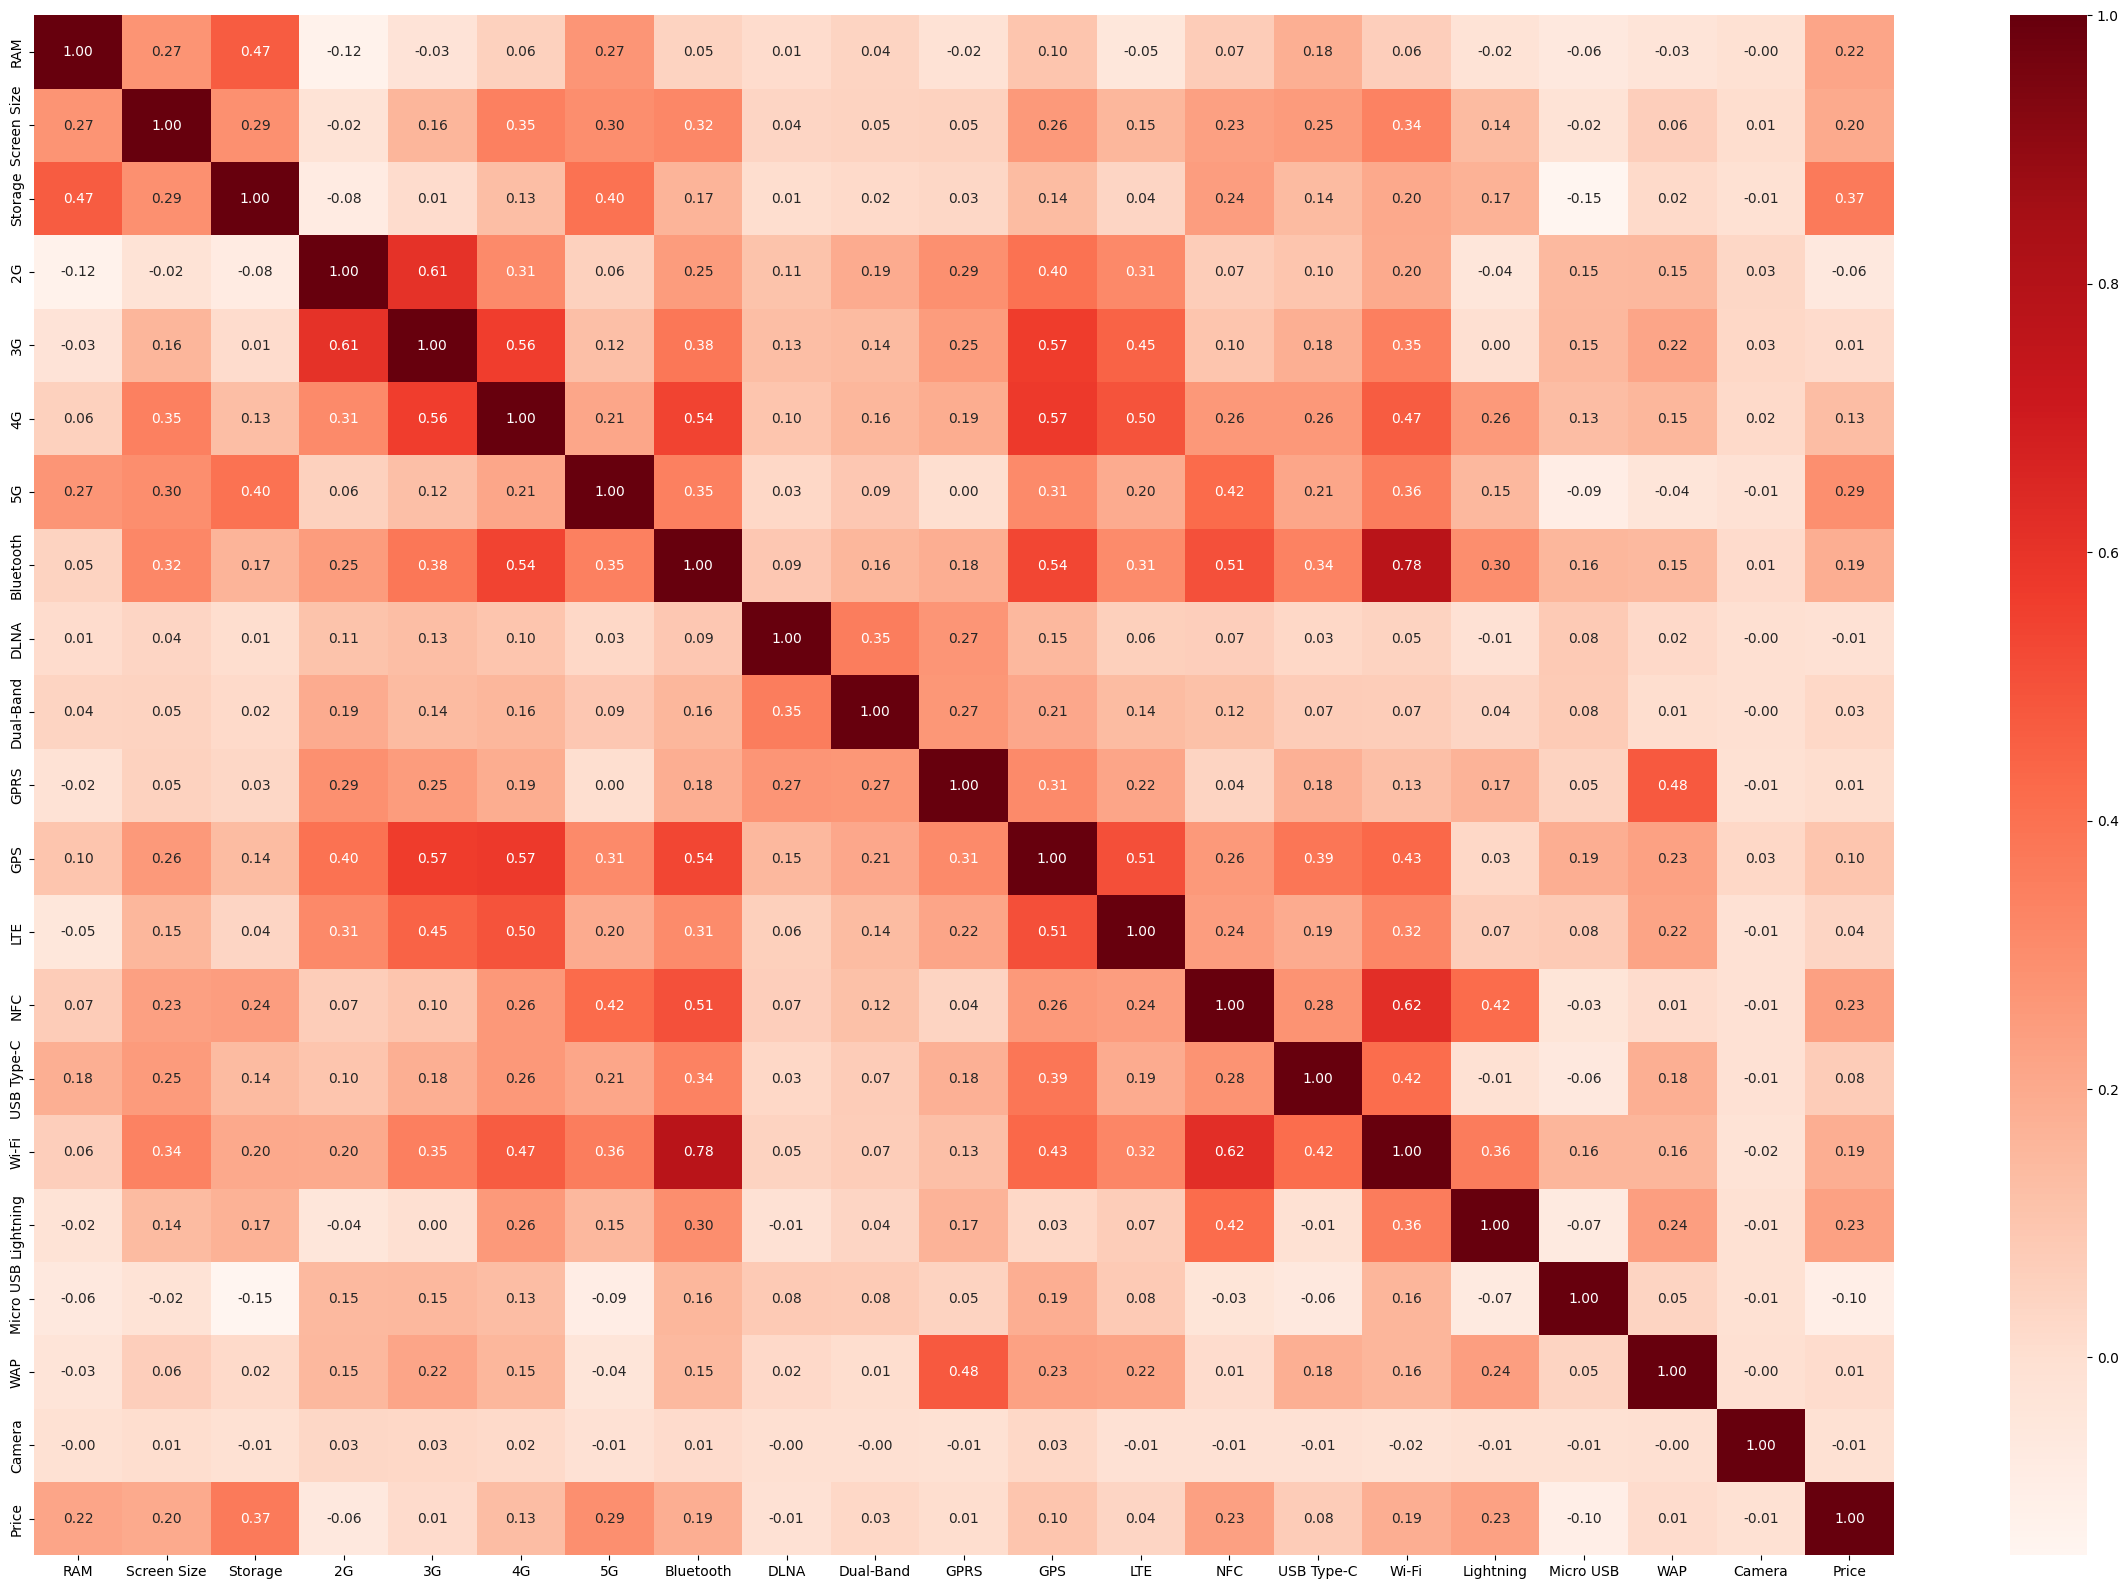

In [ ]:
#Plotting a heat map to show correlation between the variables
plt.figure(figsize=(30,20))
sns.heatmap(sales.corr(),annot=True,cmap="Reds",fmt=".2f");
plt.show()

##Plot Price Distribution


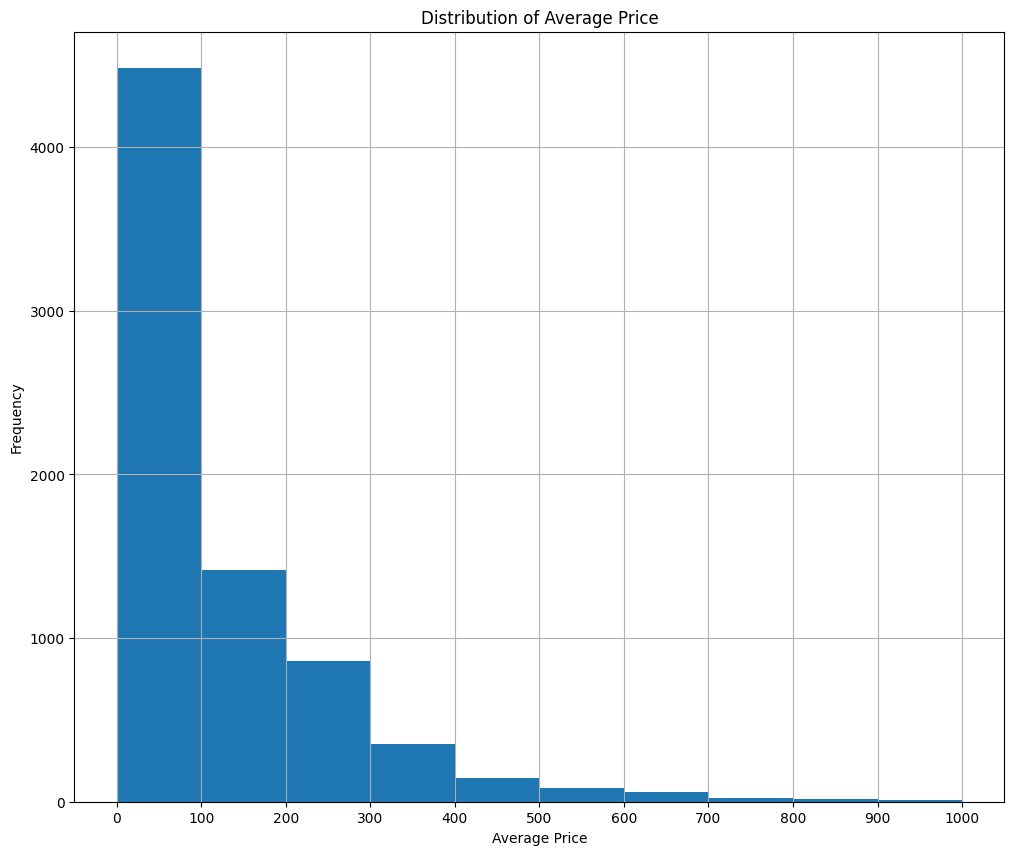

In [ ]:
plt.figure(figsize=(12,10))
sales['Price'].hist(bins=range(0, 1100, 100))
plt.title('Distribution of Average Price')
plt.xlabel('Average Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 1100,100))
plt.show()

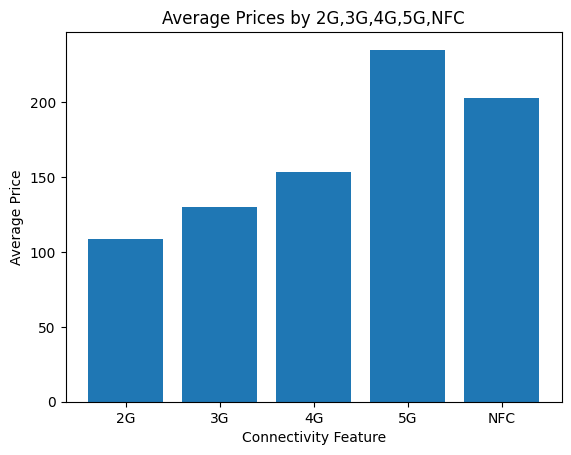

In [ ]:
features = ['2G', '3G', '4G', '5G', 'NFC']
average_prices =[sales[sales[feature] == 1]['Price'].mean() for feature in features]

plt.bar(features, average_prices)
plt.xlabel('Connectivity Feature')
plt.ylabel('Average Price')
plt.title('Average Prices by 2G,3G,4G,5G,NFC')
plt.show()

##Brand popularity and price

In [ ]:
import pandas as pd
sales['Price']=sales['Price'].astype(str)
#converting price string to numeric for aanalysis
sales['Price']=sales['Price'].str.extract('(\d+\.\d+)').astype(float)
#Analyze average price by brand
average_price=sales.groupby('Brand')['Price'].mean()
print(average_price)

Brand
1 +                           149.990000
AA                            219.490000
ClearPHONE 220                249.450000
LeEco                          84.590000
NA                             55.146667
                                 ...    
yulong                         48.990000
zebra                         117.000000
zte                            43.880500
zte, alcatel one touch,ans     25.000000
zuum                           54.963333
Name: Price, Length: 241, dtype: float64


##Storage and Price

In [ ]:
#Ensure 'Price' and 'Storage' are treated as strings and handle missing values if any
sales['Price'] = sales['Price'].astype(str)
sales['Storage'] = sales['Storage'].astype(str)

# Split the string, take the first value, extract numeric part, and convert to float
sales['Price'] = sales['Price'].str.split().str[0]
sales['Price'] = sales['Price'].str.extract('(\d+\.\d+|\d+)').astype(float)

# Extract numeric value from Storage and convert to numeric
sales['Storage'] = sales['Storage'].str.extract('(\d+)').astype(float)

# Analyze relationship between Storage and Price
storage_price_analysis = sales.groupby('Storage')['Price'].mean()
print(storage_price_analysis)

Storage
0.0          39.524000
1.0          74.442368
2.0          54.524706
3.0          51.683226
4.0          36.291974
               ...    
63114.0      66.892303
65536.0     168.958998
131072.0    221.825943
262144.0    270.645066
524288.0    308.976667
Name: Price, Length: 106, dtype: float64


# Data Preprocessing

In [ ]:
#remove outliers from float values
for col in sales.columns:
    if sales[col].dtype == 'float64':
        print(col)

RAM
Screen Size
Storage
Camera
Price


## Remove Outliers

In [ ]:
def remove_outliers(sales, column_names):
  # Create a copy of the dataframe to avoid modifying the original data
    filtered_data = sales.copy()

    for column_name in column_names:
    # Check if the column is numerical
        if pd.api.types.is_numeric_dtype(sales[column_name]):
    # Calculate Q1, Q3 and IQR for each specified column
            Q1 = sales[column_name].quantile(0.25)
            Q3 = sales[column_name].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

    # Filter the data for each column independently
            condition = (sales[column_name] >= lower_bound) & (sales[column_name] <= upper_bound)
            filtered_data = filtered_data.loc[condition]

    return filtered_data

# Apply the function to your dataframe and the specific columns
filtered_data = remove_outliers(sales, ['RAM', 'Screen Size', 'Camera', 'Storage', 'Price'])


In [ ]:
#Encoding is only for strings
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()

In [ ]:
colums=['Name','Processor','Model','Brand','OS','2G','3G','4G','5G','Bluetooth','DLNA','Dual-Band','GPRS','GPS','LTE','NFC','USB Type-C','Wi-Fi','Lightning','Micro USB','WAP']
for col in colums:
    filtered_data[col] = lab.fit_transform(filtered_data[col])
filtered_data

,Name,RAM,Processor,Model,Brand,Screen Size,OS,Storage,2G,3G,...,GPS,LTE,NFC,USB Type-C,Wi-Fi,Lightning,Micro USB,WAP,Camera,Price
0,3557,4096.000000,77,1379,203,7.300000,0,131072.0,1,1,...,1,1,1,0,1,0,0,0,5.000000e+02,127.99
1,3151,8192.000000,65,1272,135,6.700000,3,131072.0,0,0,...,0,0,1,1,1,0,0,0,5.000000e+02,269.99
3,3562,4096.000000,47,1378,203,7.300000,0,65536.0,0,1,...,1,1,0,1,1,0,0,0,5.000000e+01,109.47
5,1225,3965.113093,64,1386,41,4.703390,3,131072.0,0,0,...,0,0,0,0,0,0,0,0,9.284761e+06,79.99
7,526,4096.000000,52,206,16,6.100000,7,65536.0,0,0,...,0,0,1,0,1,1,0,0,1.200000e+02,284.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8503,3676,4096.000000,67,380,168,1.800000,0,128.0,1,0,...,0,0,0,0,0,0,0,0,8.000000e+01,40.00
8504,2228,2048.000000,64,939,114,6.072032,0,8192.0,0,0,...,0,0,0,0,0,0,0,0,9.284761e+06,33.20
8505,3536,8192.000000,64,1419,168,3.152045,3,63114.0,1,0,...,0,0,0,0,0,0,0,0,9.284761e+06,100.00
8506,3523,3965.113093,64,1351,152,4.703390,3,32768.0,0,0,...,0,0,0,0,0,0,0,0,9.284761e+06,43.00


## Data split into X and Y

In [ ]:
Y =filtered_data['Price']
Y

0       127.99
1       269.99
3       109.47
5        79.99
7       284.95
         ...  
8503     40.00
8504     33.20
8505    100.00
8506     43.00
8507    236.00
Name: Price, Length: 6604, dtype: float64

In [ ]:
X =filtered_data.drop("Price", axis = 1)

In [ ]:
print(Y.dtype)

float64


In [ ]:
print(X.dtypes)

Name             int64
RAM            float64
Processor        int64
Model            int64
Brand            int64
Screen Size    float64
OS               int64
Storage        float64
2G               int64
3G               int64
4G               int64
5G               int64
Bluetooth        int64
DLNA             int64
Dual-Band        int64
GPRS             int64
GPS              int64
LTE              int64
NFC              int64
USB Type-C       int64
Wi-Fi            int64
Lightning        int64
Micro USB        int64
WAP              int64
Camera         float64
dtype: object


## Data Split into Train and Test

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,random_state=42)

In [ ]:
print(Y_train.ndim)
print(Y_test.ndim)

1
1


In [ ]:
from sklearn.preprocessing import MinMaxScaler
Y_train_reshaped = np.array(Y_train).reshape(-1,1)
Y_test_reshaped = np.array(Y_test).reshape(-1,1)
scaler_x = MinMaxScaler()
X_train_scale = scaler_x.fit_transform(X_train)

scaler_y = MinMaxScaler()
Y_train_scale = scaler_y.fit_transform(Y_train_reshaped)


#Data Modeling & Evaluation

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
LR= LinearRegression()
LR.fit(X_train_scale,Y_train_scale)
Y_pred = LR.predict(X_test)

mse_lr= mean_squared_error(Y_test, Y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Mean Squared Error: ",mse_lr)
print("Root of mean square error:",rmse_lr)

Mean Squared Error:  27808507342.901222
Root of mean square error: 166758.8298798634


In [ ]:
Y_pred

array([[ 7140.59204232],
       [  258.26203737],
       [13618.37394002],
       ...,
       [  636.22711665],
       [27250.31909182],
       [13852.61536143]])

In [ ]:
Y_pred_inverse=scaler_y.inverse_transform(Y_pred)
Y_pred_inverse

array([[ 2662583.97074096],
       [   96300.75849449],
       [ 5078019.28475302],
       ...,
       [  237236.37725568],
       [10161098.99295751],
       [ 5165363.22596903]])

## Decision Tree

In [ ]:
decision_tree =DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train_scale, Y_train_scale)
Y_pred_dt = decision_tree.predict(X_test)
print(Y_pred_dt)

[0.10451083 0.10451083 0.10451083 ... 0.10451083 0.10451083 0.10451083]


In [ ]:
mse_dt = mean_squared_error(Y_test, Y_pred_dt)
rmse_dt=np.sqrt(mse_dt)
print("Decision tree")
print('Mean Squared Error:',mse_dt)
print('Root of mean square error:',rmse_dt)

Decision tree
Mean Squared Error: 16780.952509067345
Root of mean square error: 129.54131583810374


## Random Forest

In [ ]:
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train_scale, Y_train_scale)
Y_pred_rf = random_forest.predict(X_test)
Y_pred_rf

array([0.3510197 , 0.34700493, 0.36683866, ..., 0.32955133, 0.36489407,
       0.37566301])

In [ ]:
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
rmse_rf=np.sqrt(mse_rf)
print("Mean square error:",mse_rf)
print("Root of Mean square error:",rmse_rf)

Mean square error: 16732.2117468851
Root of Mean square error: 129.35305078306078


## SVM Regression

In [ ]:
svm = SVR(kernel='linear')
svm.fit(X_train_scale, Y_train_scale)
svm_pred = svm.predict(X_test)
svm_pred

array([ 7182.80548937,   272.55307112, 13742.35212329, ...,
         640.17914123, 27509.18758532, 13942.37449105])

In [ ]:
# Evaluate the model
svm_mse = mean_squared_error(Y_test, svm_pred)
svm_rmse = np.sqrt(svm_mse)
print(f"Mean Square Error(MSE):{svm_mse}")
print(f"Root Mean Squared Error (RMSE): {svm_rmse}")

Mean Square Error(MSE):49651467725.104256
Root Mean Squared Error (RMSE): 222826.09300776303


## XGBoost Regression

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train_scale, Y_train_scale)
xgb_pred = xgb.predict(X_test)
xgb_pred

array([0.46847245, 0.37547055, 0.4992014 , ..., 0.25294104, 0.46850795,
       0.4806715 ], dtype=float32)

In [ ]:
xgb_mse = mean_squared_error(Y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
print(f"Mean Square Error (MSE):{xgb_mse}")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse}")

Mean Square Error (MSE):16726.95122918556
Root Mean Squared Error (RMSE): 129.3327152316287


## K Nearest Neighbors

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scale, Y_train_scale)
Y_pred_knn = knn.predict(X_test)
Y_pred_knn

array([[0.53651577],
       [0.52667882],
       [0.53651577],
       ...,
       [0.51325896],
       [0.53651577],
       [0.53651577]])

In [ ]:
# Calculate metrics
mse_knn = mean_squared_error(Y_test, Y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
print("Mean squared error:", mse_knn)
print("Root mean squared error:", rmse_knn)

Mean squared error: 16708.26047412715
Root mean squared error: 129.26043661587698


##Important features

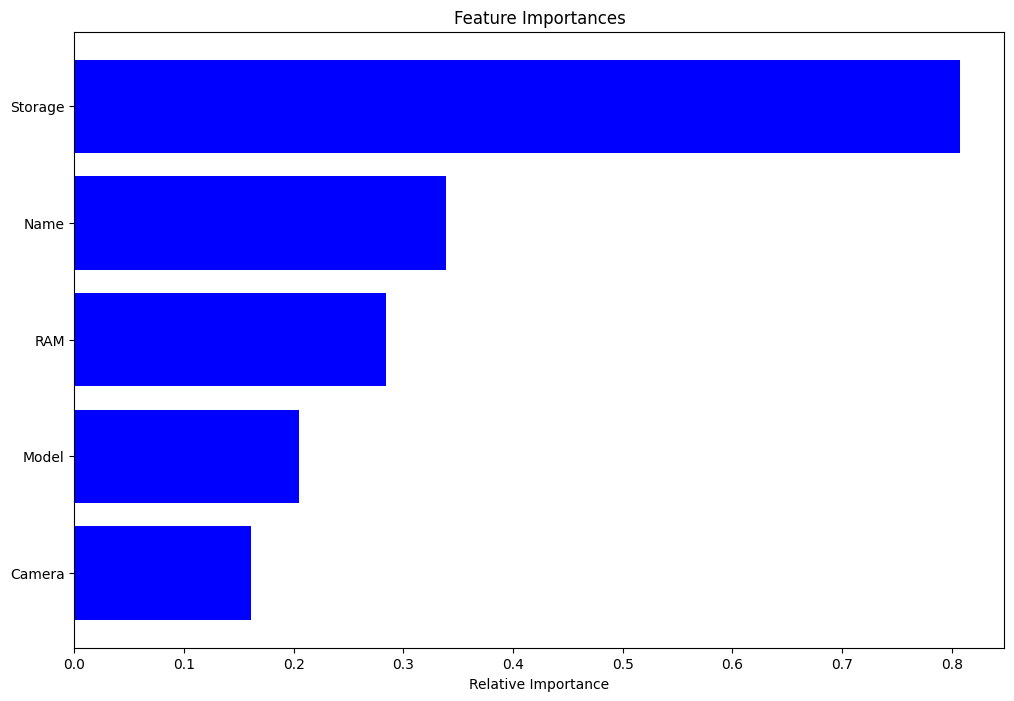

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import pandas as pd

# Compute the permutation importances
perm_importance = permutation_importance(knn_model, X_train, Y_train, n_repeats=30)

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': perm_importance.importances_mean})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(feature_importances['feature'][:5], feature_importances['importance'][:5], color='b', align='center')
plt.gca().invert_yaxis()
plt.xlabel('Relative Importance')
plt.show()
